In [282]:
from trains import Task

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import  torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [201]:
import sys
import seaborn as sns
sys.path.append('/home/aggelos/PersonalProjects/ForecastingLib/')
from tsutils import SequenceSpliter
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [46]:
class TimeSeriesDataSet(Dataset):

    def __init__(self, datafile, features, lookback, feature_to_reconstruct):
        self.features = features
        self.feature_to_reconstruct = feature_to_reconstruct
        self.lookback = lookback

        df = pd.read_csv(datafile, usecols=self.features, delimiter='\t')
        df = df.rolling(lookback).mean().dropna()
        spliter = SequenceSpliter(lookback, 1)
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df)
        df.iloc[:, :] = scaled
        X, _ = spliter.fit_transform(df.values)
        X = np.swapaxes(X, 1,2)
        self.target_idx = df.columns.get_loc(self.feature_to_reconstruct)
        self.dataset = torch.Tensor(X)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        return torch.Tensor(self.dataset[item])


workers = 4

batch_size = 128

lookback = 128

noise_size = 10

num_epochs = 2

lr = 0.0002

beta1 = 0.5

features = ['voltage [V]',
            'acceleration (actual) [m/(s*s)]',
            'tractive effort (actual) [kN]',
            'track-earth voltage [V]',
            'speed (actual) [km/h]',
            'current [A]',
            'energy balance [kWh]',
            'way (actual) [km]',
            'line and running resistance [kN]',
            'train configuration [1]',
            'energy input [kWh]',
            'train configuration [1]',
            'usable braking energy [kWh]',
            'used braking energy [kWh]'
            ]

nb_features = len(features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33NO/7hnz0038.xls",
                            lookback=128,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)

validation_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33NO/7hnz0040.xls",
                            lookback=128,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)


In [158]:
class Encoder(nn.Module):
    """This is the encoder part of the autoencoder"""
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(13, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, stride=2, dilation=2, padding=2)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, stride=2, dilation=4, padding=4)
        self.conv4 = nn.Conv1d(32 ,16, kernel_size=3, stride=2, dilation=8, padding=8)
        self.conv5 = nn.Conv1d(16 ,8, kernel_size=3, stride=2, dilation=16, padding=16)
        self.conv6 = nn.Conv1d(8 ,4, kernel_size=3, stride=2, dilation=32, padding=32)
        self.activation = nn.ReLU()

    
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.activation(self.conv5(x))
        x = self.conv6(x)

        return x
        

In [159]:
class Decoder(nn.Module):
    def __init__(self):
        """The decoder part of the autoencoder """
        
        super().__init__()
        self.covn1 = nn.ConvTranspose1d(4, 8, 4, stride=1)
        self.covn2 = nn.ConvTranspose1d(8, 16, 8, stride=1)
        self.covn3 = nn.ConvTranspose1d(16, 32, 16, stride=1)
        self.covn4 = nn.ConvTranspose1d(32, 64, 32, stride=1)
        self.covn5 = nn.ConvTranspose1d(64, 128, 64, stride=1)
        self.conv6 = nn.ConvTranspose1d(128, 13, 8, stride=1, padding=1)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = self.activation(self.covn1(x))
        x = self.activation(self.covn2(x))
        x = self.activation(self.covn3(x))
        x = self.activation(self.covn4(x))
        x = self.activation(self.covn5(x))
        x = self.conv6(x)
        return x

In [160]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        code = self.encoder(x)
        self.code = code
        reconstructed = self.decoder(code)
        return reconstructed

In [163]:
ae = AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters())
history_train_loss = []
history_val_loss = []
dataloaders = {'train': train_dataloader,
              'validation': validation_dataloader}

In [281]:
ae.encoder
ae.decoder

Decoder(
  (covn1): ConvTranspose1d(4, 8, kernel_size=(4,), stride=(1,))
  (covn2): ConvTranspose1d(8, 16, kernel_size=(8,), stride=(1,))
  (covn3): ConvTranspose1d(16, 32, kernel_size=(16,), stride=(1,))
  (covn4): ConvTranspose1d(32, 64, kernel_size=(32,), stride=(1,))
  (covn5): ConvTranspose1d(64, 128, kernel_size=(64,), stride=(1,), padding=(1,))
  (conv6): ConvTranspose1d(128, 13, kernel_size=(8,), stride=(1,))
  (activation): LeakyReLU(negative_slope=0.01)
)

In [164]:
for epoch in tqdm(range(50)):
    for mode, dataloader in dataloaders.items():
        for batch in dataloader:
                if mode == 'train':
                    ae.train()
                    optimizer.zero_grad()
                    reconstructed = ae(batch)
                    train_loss = criterion(reconstructed, batch)
                    train_loss.backward()
                    optimizer.step()
                    history_train_loss.append(train_loss.item())

                else:
                    ae.eval()
                    reconstructed = ae(batch)
                    val_loss = criterion(reconstructed, batch)
                    history_val_loss.append(val_loss.item())
    if epoch%3 == 0:
        print(f"Epoch: {epoch+1}, Train_Loss: {train_loss.item()}, Val_loss: {val_loss.item()}")
            







  0%|          | 0/50 [00:00<?, ?it/s]




  2%|▏         | 1/50 [00:07<05:53,  7.21s/it]

Epoch: 1, Train_Loss: 0.9504269361495972, Val_loss: 0.603323221206665







  4%|▍         | 2/50 [00:14<05:46,  7.22s/it]




  6%|▌         | 3/50 [00:21<05:42,  7.29s/it]




  8%|▊         | 4/50 [00:29<05:38,  7.36s/it]

Epoch: 4, Train_Loss: 0.645101010799408, Val_loss: 0.6263560056686401







 10%|█         | 5/50 [00:36<05:33,  7.40s/it]




 12%|█▏        | 6/50 [00:44<05:29,  7.48s/it]




 14%|█▍        | 7/50 [00:52<05:24,  7.54s/it]

Epoch: 7, Train_Loss: 0.8321056365966797, Val_loss: 0.6278263926506042







 16%|█▌        | 8/50 [00:59<05:18,  7.58s/it]




 18%|█▊        | 9/50 [01:07<05:08,  7.51s/it]




 20%|██        | 10/50 [01:14<05:00,  7.52s/it]

Epoch: 10, Train_Loss: 0.3758396506309509, Val_loss: 0.8316266536712646







 22%|██▏       | 11/50 [01:22<04:52,  7.51s/it]




 24%|██▍       | 12/50 [01:29<04:45,  7.51s/it]




 26%|██▌       | 13/50 [01:37<04:39,  7.56s/it]

Epoch: 13, Train_Loss: 0.49763041734695435, Val_loss: 0.9082040190696716







 28%|██▊       | 14/50 [01:45<04:31,  7.54s/it]




 30%|███       | 15/50 [01:52<04:24,  7.55s/it]




 32%|███▏      | 16/50 [02:00<04:21,  7.68s/it]

Epoch: 16, Train_Loss: 0.4356131851673126, Val_loss: 0.7674486041069031







 34%|███▍      | 17/50 [02:08<04:12,  7.65s/it]




 36%|███▌      | 18/50 [02:16<04:09,  7.79s/it]




 38%|███▊      | 19/50 [02:24<04:01,  7.79s/it]

Epoch: 19, Train_Loss: 0.3015329837799072, Val_loss: 0.3495599627494812







 40%|████      | 20/50 [02:31<03:51,  7.73s/it]




 42%|████▏     | 21/50 [02:40<03:53,  8.04s/it]




 44%|████▍     | 22/50 [02:48<03:42,  7.95s/it]

Epoch: 22, Train_Loss: 0.396537184715271, Val_loss: 0.2603093087673187







 46%|████▌     | 23/50 [02:57<03:42,  8.24s/it]




 48%|████▊     | 24/50 [03:04<03:31,  8.12s/it]




 50%|█████     | 25/50 [03:12<03:19,  8.00s/it]

Epoch: 25, Train_Loss: 0.293329656124115, Val_loss: 0.28011780977249146







 52%|█████▏    | 26/50 [03:20<03:10,  7.92s/it]




 54%|█████▍    | 27/50 [03:28<03:00,  7.87s/it]




 56%|█████▌    | 28/50 [03:35<02:52,  7.82s/it]

Epoch: 28, Train_Loss: 0.16937844455242157, Val_loss: 0.1842539757490158







 58%|█████▊    | 29/50 [03:43<02:42,  7.73s/it]




 60%|██████    | 30/50 [03:51<02:34,  7.72s/it]




 62%|██████▏   | 31/50 [03:58<02:25,  7.65s/it]

Epoch: 31, Train_Loss: 0.26657265424728394, Val_loss: 0.19501814246177673







 64%|██████▍   | 32/50 [04:06<02:18,  7.70s/it]




 66%|██████▌   | 33/50 [04:14<02:11,  7.71s/it]




 68%|██████▊   | 34/50 [04:21<02:03,  7.73s/it]

Epoch: 34, Train_Loss: 0.17647166550159454, Val_loss: 0.14639492332935333







 70%|███████   | 35/50 [04:30<02:00,  8.06s/it]




 72%|███████▏  | 36/50 [04:39<01:54,  8.21s/it]




 74%|███████▍  | 37/50 [04:47<01:48,  8.33s/it]

Epoch: 37, Train_Loss: 0.15250593423843384, Val_loss: 0.1798730045557022







 76%|███████▌  | 38/50 [04:57<01:43,  8.65s/it]




 78%|███████▊  | 39/50 [05:06<01:37,  8.87s/it]




 80%|████████  | 40/50 [05:14<01:26,  8.60s/it]

Epoch: 40, Train_Loss: 0.16254550218582153, Val_loss: 0.13352090120315552







 82%|████████▏ | 41/50 [05:22<01:15,  8.36s/it]




 84%|████████▍ | 42/50 [05:29<01:04,  8.12s/it]




 86%|████████▌ | 43/50 [05:37<00:55,  7.98s/it]

Epoch: 43, Train_Loss: 0.10548284649848938, Val_loss: 0.18326222896575928







 88%|████████▊ | 44/50 [05:45<00:47,  7.92s/it]




 90%|█████████ | 45/50 [05:53<00:39,  7.92s/it]




 92%|█████████▏| 46/50 [06:01<00:31,  7.93s/it]

Epoch: 46, Train_Loss: 0.141424298286438, Val_loss: 0.13684555888175964







 94%|█████████▍| 47/50 [06:09<00:23,  7.92s/it]




 96%|█████████▌| 48/50 [06:16<00:15,  7.88s/it]




 98%|█████████▊| 49/50 [06:24<00:07,  7.87s/it]

Epoch: 49, Train_Loss: 0.15107357501983643, Val_loss: 0.16479194164276123







100%|██████████| 50/50 [06:33<00:00,  8.00s/it]






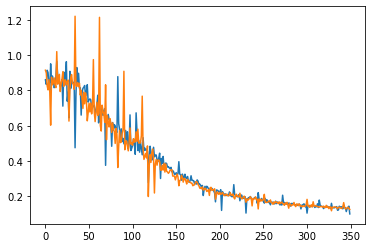

In [174]:
plt.plot(history_train_loss)
plt.plot(history_val_loss)

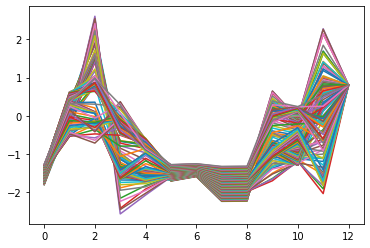

In [175]:
plt.plot(dataset[0].detach().numpy())

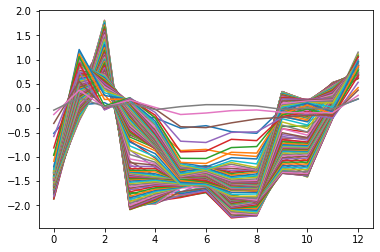

In [176]:
plt.plot(ae(dataset[0:1]).detach().numpy()[0])

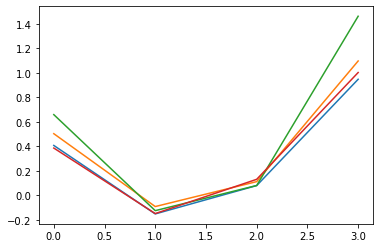

In [177]:
plt.plot(ae.code.detach().numpy()[0])

In [250]:
reconstructed = ae(train_dataset[:])
reconstruction_loss = np.mean((reconstructed.detach().numpy() - train_dataset[:].detach().numpy())**2, axis=(2))
reconstruction_loss.shape

(772, 13)

In [273]:
faulty_dataset = TimeSeriesDataSet("~/Downloads/simu_Elbas/7h33D1/7hnz0038.xls",
                            lookback=128,
                            features=features,
                            feature_to_reconstruct='voltage [V]')

In [274]:
reconstructed = ae(faulty_dataset[:])
abnormal_reconstruction_error = np.mean(((reconstructed.detach().numpy()) - (faulty_dataset[:].detach().numpy()))**2, axis=(2))

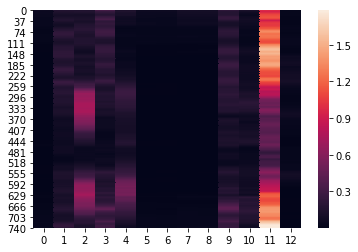

In [275]:
sns.heatmap(abnormal_reconstruction_error)


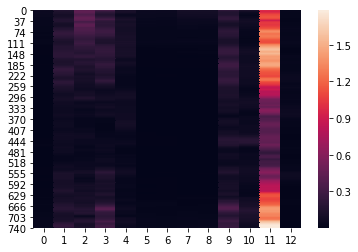

In [276]:
sns.heatmap(reconstruction_loss)

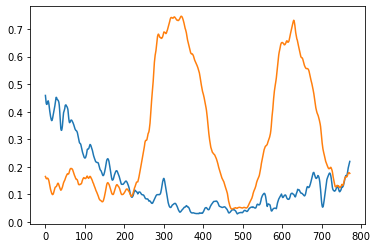

In [278]:
plt.plot(reconstruction_loss[:,2])
plt.plot(abnormal_reconstruction_error[:,2])

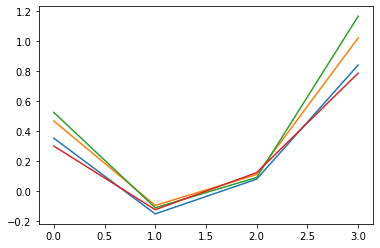

In [182]:
plt.plot(ae.code.detach().numpy()[0])

In [279]:
ae.code.shape

torch.Size([772, 4, 4])